In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)
from sklearn.linear_model import SGDClassifier
import shap

In [85]:
df = pd.read_csv('./Loan Status Prediction.csv') #Load Dataset
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Check for skewness and normality

In [86]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns #Get Numerical Columns
num_cols

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [87]:
df[num_cols].skew() #Check for skewness

ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.677552
Loan_Amount_Term    -2.362414
Credit_History      -1.882361
dtype: float64

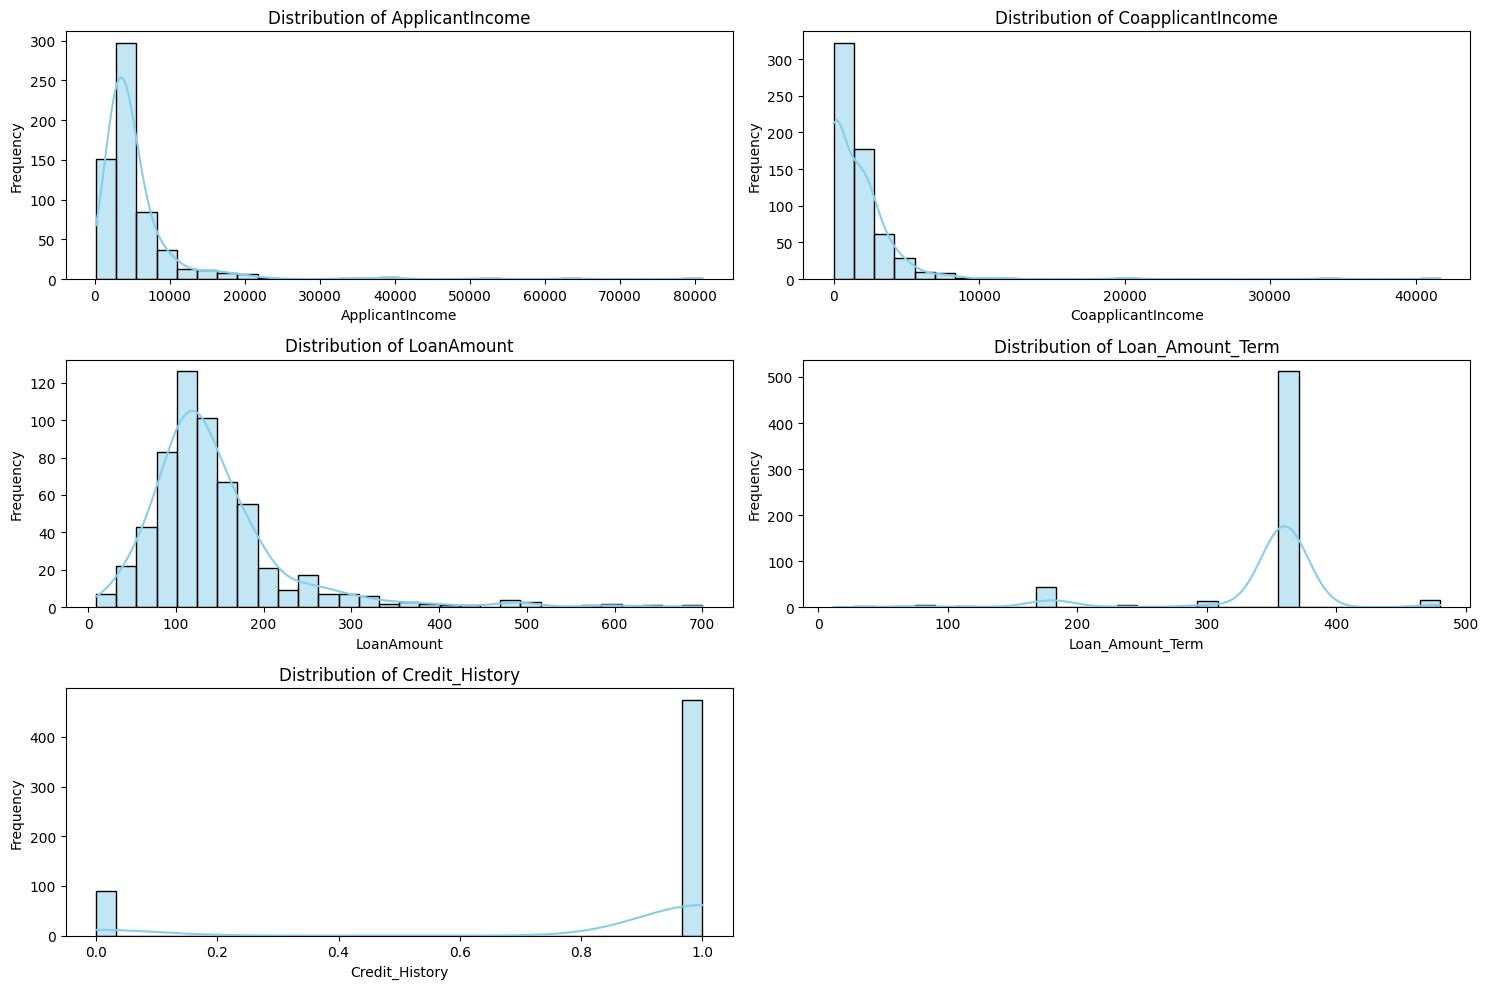

In [88]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}", fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [89]:
missing_values = df.isna().sum()
missing_values

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [90]:
all_values = df.shape[0]
missing_percentage = (missing_values / all_values) * 100
print('Missing Data Percentage per Column:')
missing_percentage

Missing Data Percentage per Column:


Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

**Handle missing data**

Dropping all the missing data points

In [91]:
df = df.dropna()  # Drop rows with missing values
df.shape

(480, 13)

**Handling Outlier Data points**

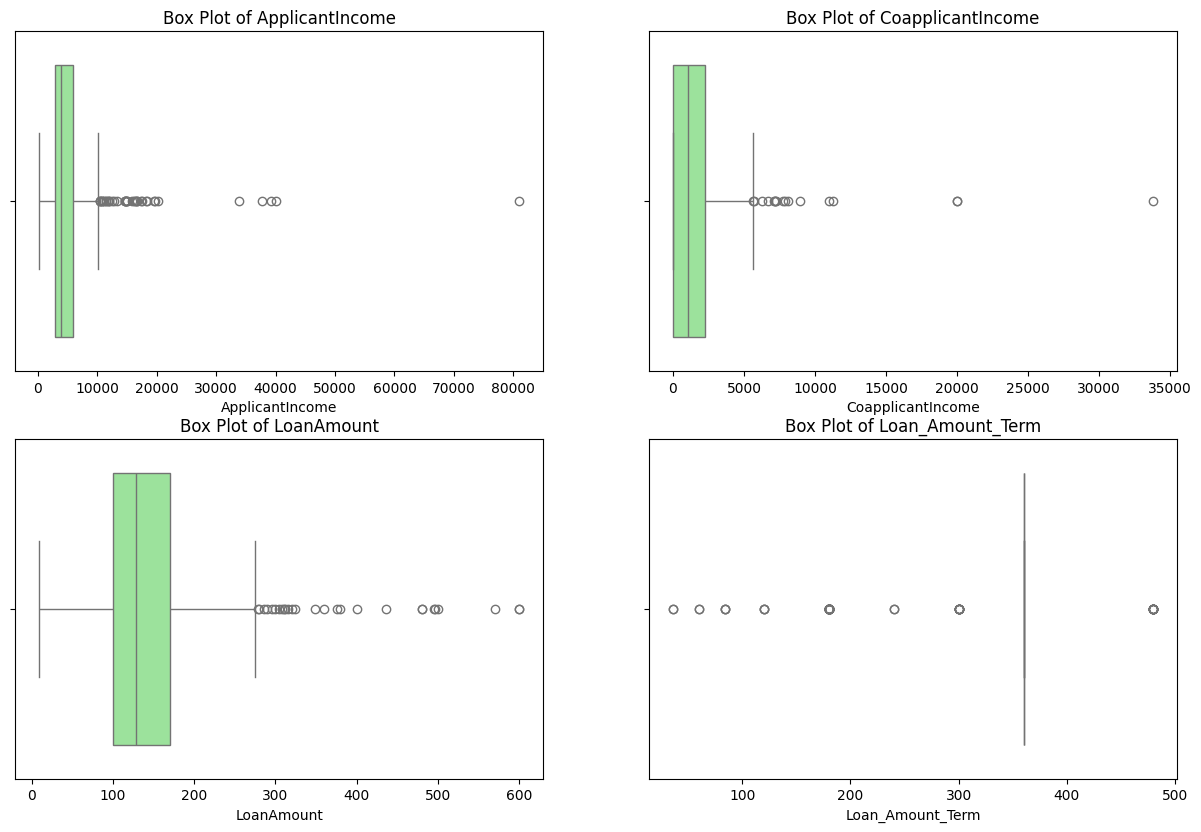

In [92]:
num_cols = num_cols.drop('Credit_History')  # Exclude 'Credit_History' because it is categorical
# Box plots to visualize outliers
plt.figure(figsize=(15, 15))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Box Plot of {col}", fontsize=12)
    plt.xlabel(col)

In [93]:

Q1 = df[num_cols].quantile(0.25) #First Quartile
Q3 = df[num_cols].quantile(0.75) #Third Quartile
IQR = Q3 - Q1

df_clean = df.copy()

# Loop through each numerical column and remove outliers
for col in num_cols:
    if col == 'LoanAmount':
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Keep only data within the IQR bounds
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f"Outliers removed. New dataset shape: {df_clean.shape}")


Outliers removed. New dataset shape: (453, 13)


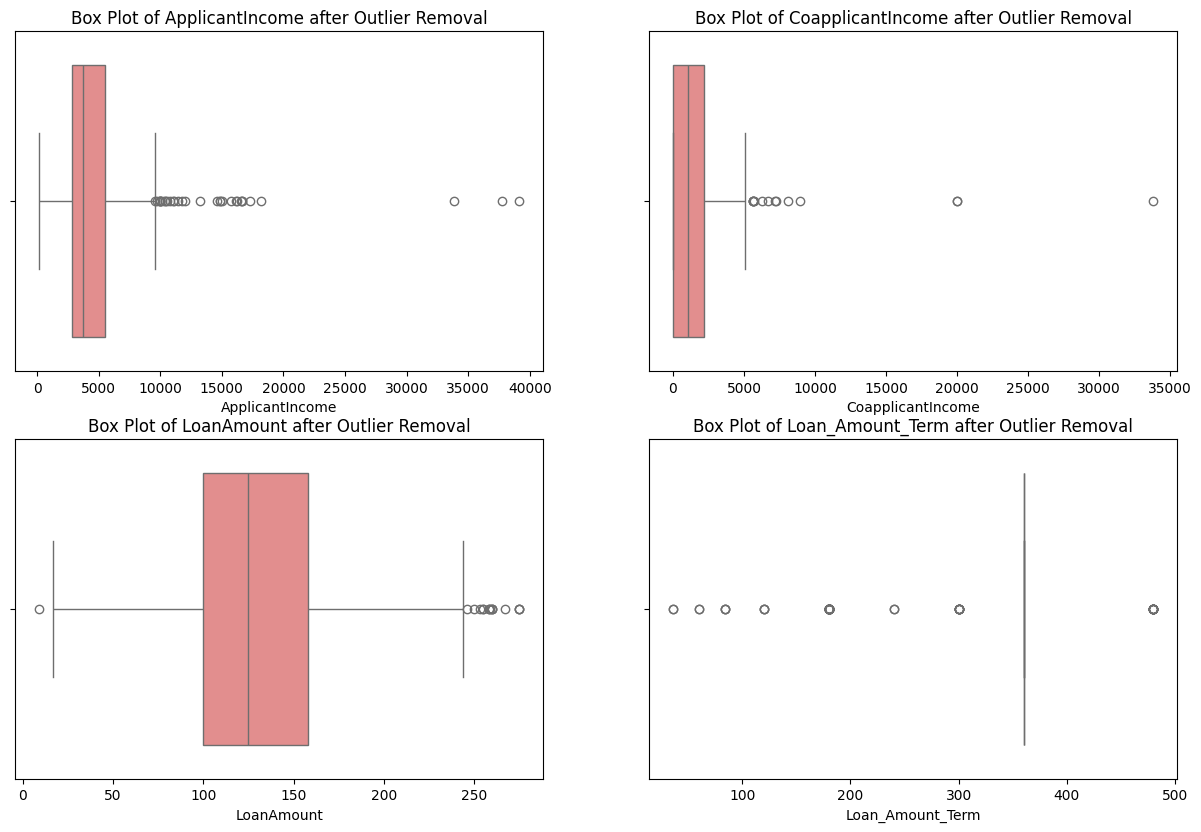

In [94]:
# Box plots to visualize after outlier removal
plt.figure(figsize=(15, 15))

#loop trhough each numerical column and plot boxplots
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=df_clean[col], color='lightcoral')
    plt.title(f"Box Plot of {col} after Outlier Removal", fontsize=12)
    plt.xlabel(col)

In [95]:
df = df_clean  # Update original dataframe
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome'] #Create Total Income Feature

df['LoanAmountPerIncome'] = df['LoanAmount'] / df['TotalIncome'] # Create Laon Amount Per Income Feature
# Replace infinite values with NaN if TotalIncome is 0
df['LoanAmountPerIncome'] = df['LoanAmountPerIncome'].replace([np.inf, -np.inf], np.nan)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,LoanAmountPerIncome
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0.021015
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,0.022000
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,0.024287
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,0.023500
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0,0.027775


In [96]:
num_col = df.select_dtypes(include=['int64', 'float64']).columns #Get Numerical Columns
num_col

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'TotalIncome',
       'LoanAmountPerIncome'],
      dtype='object')

In [97]:
df[num_col].skew() #Check for skewness

ApplicantIncome        4.573238
CoapplicantIncome      6.772089
LoanAmount             0.516371
Loan_Amount_Term      -2.303721
Credit_History        -2.040665
TotalIncome            4.289105
LoanAmountPerIncome    1.164054
dtype: float64

In [98]:
# Calculate skewness for numeric columns
skewed_cols = df[num_col].skew()
# Filter columns with absolute skewness > 0.5
skewed_cols = skewed_cols[skewed_cols.abs() > 0.5].index

skewed_cols

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'TotalIncome',
       'LoanAmountPerIncome'],
      dtype='object')

In [99]:
skewed_cols = df[num_col].skew()
skewed_cols = skewed_cols[skewed_cols.abs() > 0.5].index

# Copy dataframe to preserve original
df_transformed = df.copy()

# Apply transformations
df_transformed['LoanAmountPerIncome'] = np.sqrt(df_transformed['LoanAmountPerIncome']) 
df_transformed["CoapplicantIncome"] = np.sqrt(df_transformed["CoapplicantIncome"]) 
df_transformed['ApplicantIncome'] = np.cbrt(df_transformed['ApplicantIncome'])
df_transformed["TotalIncome"] = np.log1p(df_transformed["TotalIncome"])

# Credit_History is categorical, so we skip it

# Check skewness again after transformation
new_skew = df_transformed[skewed_cols].skew()
print("Skewness after transformation:")
print(new_skew)

Skewness after transformation:
ApplicantIncome        1.548196
CoapplicantIncome      0.849207
LoanAmount             0.516371
Loan_Amount_Term      -2.303721
Credit_History        -2.040665
TotalIncome            0.788622
LoanAmountPerIncome   -0.386352
dtype: float64


In [100]:
df_transformed.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,LoanAmountPerIncome
1,LP001003,Male,Yes,1,Graduate,No,16.610522,38.832976,128.0,360.0,1.0,Rural,N,8.714732,0.144964
2,LP001005,Male,Yes,0,Graduate,Yes,14.422496,0.000000,66.0,360.0,1.0,Urban,Y,8.006701,0.148324
3,LP001006,Male,Yes,0,Not Graduate,No,13.720654,48.559242,120.0,360.0,1.0,Urban,Y,8.505525,0.155842
4,LP001008,Male,No,0,Graduate,No,18.171206,0.000000,141.0,360.0,1.0,Urban,Y,8.699681,0.153297
5,LP001011,Male,Yes,2,Graduate,Yes,17.562498,64.776539,267.0,360.0,1.0,Urban,Y,9.170976,0.166658


In [101]:
# Replace '3+' with 3 in Dependents column
df_transformed['Dependents'] = df_transformed['Dependents'].replace('3+', 3)

# Convert to numeric type
df_transformed['Dependents'] = pd.to_numeric(df_transformed['Dependents'])
df_transformed['Dependents'].skew() #Check skewness after conversion

np.float64(0.9721107572341706)

In [102]:
binary_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status'] #Binary Columns

le = LabelEncoder() #Label Encoder instance
for col in binary_cols:
    df_transformed[col] = le.fit_transform(df_transformed[col]) #Encode binary columns
    
df_transformed.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,LoanAmountPerIncome
1,LP001003,1,1,1,0,0,16.610522,38.832976,128.0,360.0,1.0,Rural,0,8.714732,0.144964
2,LP001005,1,1,0,0,1,14.422496,0.000000,66.0,360.0,1.0,Urban,1,8.006701,0.148324
3,LP001006,1,1,0,1,0,13.720654,48.559242,120.0,360.0,1.0,Urban,1,8.505525,0.155842
4,LP001008,1,0,0,0,0,18.171206,0.000000,141.0,360.0,1.0,Urban,1,8.699681,0.153297
5,LP001011,1,1,2,0,1,17.562498,64.776539,267.0,360.0,1.0,Urban,1,9.170976,0.166658


In [103]:
# One-Hot Encoding for Property_Area
df_transformed = pd.get_dummies(df_transformed, columns=['Property_Area'], dtype=int, drop_first=True)
df_transformed.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,LoanAmountPerIncome,Property_Area_Semiurban,Property_Area_Urban
1,LP001003,1,1,1,0,0,16.610522,38.832976,128.0,360.0,1.0,0,8.714732,0.144964,0,0
2,LP001005,1,1,0,0,1,14.422496,0.000000,66.0,360.0,1.0,1,8.006701,0.148324,0,1
3,LP001006,1,1,0,1,0,13.720654,48.559242,120.0,360.0,1.0,1,8.505525,0.155842,0,1
4,LP001008,1,0,0,0,0,18.171206,0.000000,141.0,360.0,1.0,1,8.699681,0.153297,0,1
5,LP001011,1,1,2,0,1,17.562498,64.776539,267.0,360.0,1.0,1,9.170976,0.166658,0,1


In [104]:
independent_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
                    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
                    'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanAmountPerIncome',
                    'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status']

X = df_transformed[independent_cols]

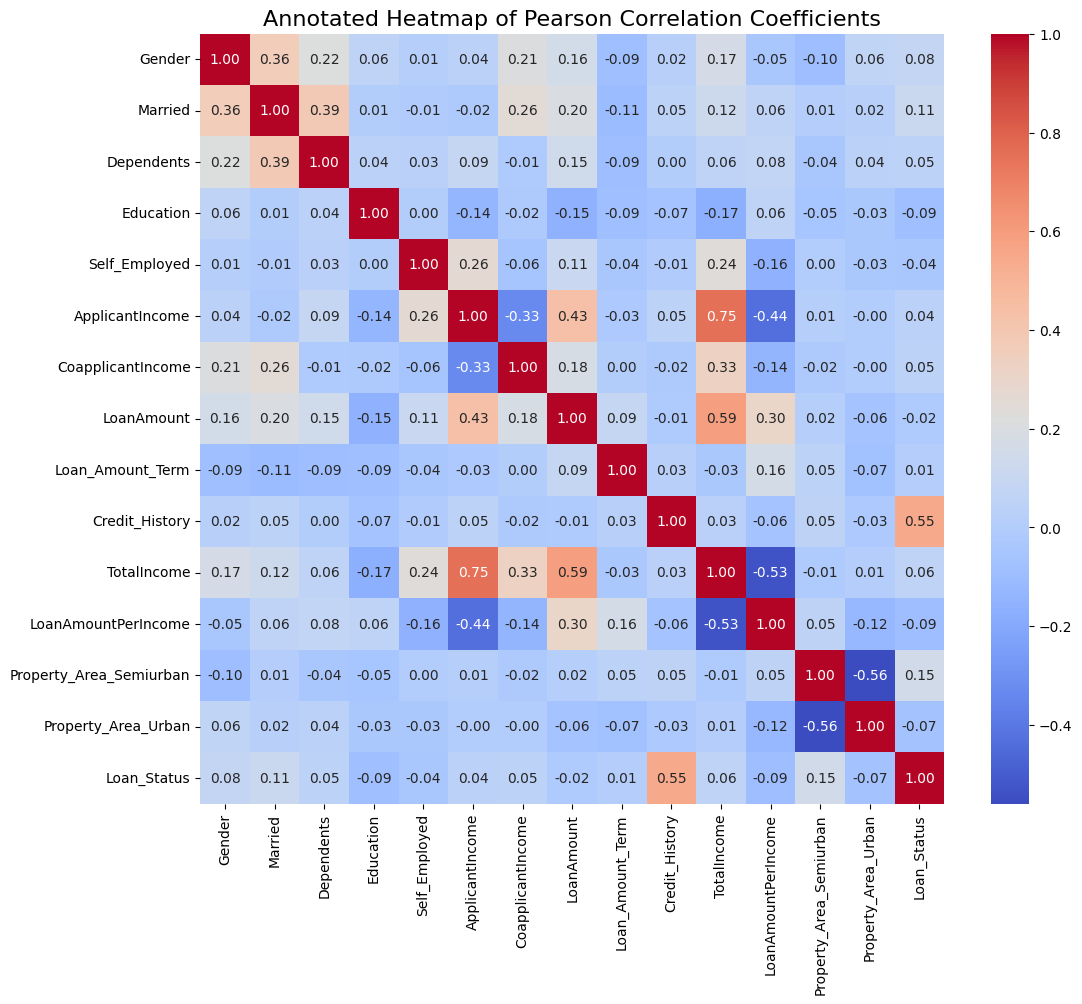

In [105]:
corr_matrix = X.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Annotated Heatmap of Pearson Correlation Coefficients', fontsize=16)
plt.show()

In [106]:
# drop columns that are least significant based on correlation analysis and domain knowledge
df_transformed = df_transformed.drop(columns=['Loan_Amount_Term', 'Loan_ID'])
df_transformed.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Status,TotalIncome,LoanAmountPerIncome,Property_Area_Semiurban,Property_Area_Urban
1,1,1,1,0,0,16.610522,38.832976,128.0,1.0,0,8.714732,0.144964,0,0
2,1,1,0,0,1,14.422496,0.000000,66.0,1.0,1,8.006701,0.148324,0,1
3,1,1,0,1,0,13.720654,48.559242,120.0,1.0,1,8.505525,0.155842,0,1
4,1,0,0,0,0,18.171206,0.000000,141.0,1.0,1,8.699681,0.153297,0,1
5,1,1,2,0,1,17.562498,64.776539,267.0,1.0,1,9.170976,0.166658,0,1


In [107]:
# Scale the features using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_transformed)

# Convert back to DataFrame for convenience
df_scaled = pd.DataFrame(df_scaled, columns=df_transformed.columns)
df_scaled.describe().round(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Status,TotalIncome,LoanAmountPerIncome,Property_Area_Semiurban,Property_Area_Urban
count,453.000,453.000,453.000,453.000,453.000,453.000,453.000,453.000,453.000,453.000,453.000,453.000,453.000,453.000
mean,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-2.127,-1.334,-0.746,-0.519,-0.391,-3.337,-0.972,-2.411,-2.443,-1.535,-2.787,-3.502,-0.816,-0.686
25%,0.470,-1.334,-0.746,-0.519,-0.391,-0.641,-0.972,-0.602,0.409,-1.535,-0.667,-0.439,-0.816,-0.686
50%,0.470,0.750,-0.746,-0.519,-0.391,-0.197,0.198,-0.105,0.409,0.652,-0.101,0.125,-0.816,-0.686
75%,0.470,0.750,1.242,-0.519,-0.391,0.452,0.724,0.550,0.409,0.652,0.535,0.578,1.226,1.457
max,0.470,0.750,2.235,1.928,2.559,5.459,5.698,2.876,0.409,0.652,4.331,4.767,1.226,1.457


In [108]:
X = df_transformed.drop('Loan_Status', axis=1) # X features
y = df_transformed['Loan_Status'] # target variable

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scale training and testing features seperately to avoid data leakage
X_test_original = X_test.copy()  # Keep a copy of original test features for later use

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert back to DataFrame for convenience
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_train.describe().round(3)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,TotalIncome,LoanAmountPerIncome,Property_Area_Semiurban,Property_Area_Urban
count,362.000,362.000,362.000,362.000,362.000,362.000,362.000,362.000,362.000,362.000,362.000,362.000,362.000
mean,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-2.024,-1.328,-0.733,-0.507,-0.386,-3.348,-0.949,-2.191,-2.442,-2.843,-3.610,-0.846,-0.669
25%,0.494,-1.328,-0.733,-0.507,-0.386,-0.626,-0.949,-0.648,0.410,-0.644,-0.428,-0.846,-0.669
50%,0.494,0.753,-0.733,-0.507,-0.386,-0.195,0.208,-0.127,0.410,-0.117,0.093,-0.846,-0.669
75%,0.494,0.753,1.255,-0.507,-0.386,0.436,0.723,0.561,0.410,0.465,0.537,1.182,1.494
max,0.494,0.753,2.250,1.973,2.589,5.501,5.704,3.001,0.410,4.455,4.768,1.182,1.494


In [109]:
X_test.describe().round(3) #Check Test Data Statistics

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,TotalIncome,LoanAmountPerIncome,Property_Area_Semiurban,Property_Area_Urban
count,91.000,91.000,91.000,91.000,91.000,91.000,91.000,91.000,91.000,91.000,91.000,91.000,91.000
mean,0.190,0.021,0.064,0.093,0.039,0.044,0.101,-0.080,0.002,0.071,-0.306,-0.177,0.115
std,0.826,0.999,1.008,1.068,1.047,1.034,0.989,1.230,1.003,1.125,1.034,0.959,1.046
min,-2.024,-1.328,-0.733,-0.507,-0.386,-1.900,-0.949,-2.545,-2.442,-2.184,-3.211,-0.846,-0.669
25%,0.494,-1.328,-0.733,-0.507,-0.386,-0.648,-0.949,-0.742,0.410,-0.750,-0.846,-0.846,-0.669
50%,0.494,0.753,-0.733,-0.507,-0.386,-0.169,0.243,-0.231,0.410,0.013,-0.078,-0.846,-0.669
75%,0.494,0.753,1.255,-0.507,-0.386,0.585,0.842,0.572,0.410,0.798,0.454,1.182,1.494
max,0.494,0.753,2.250,1.973,2.589,2.902,2.308,3.001,0.410,2.656,1.292,1.182,1.494


In [110]:
# create instance of models and store in dictionary
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=10000),
    'Support Vector Machine': SVC(C=5, random_state=42, kernel='rbf'),
    'SGD Classifier': SGDClassifier(loss='log_loss', random_state=42, max_iter=10000)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train) # Train the model
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
    }
    
    print("Training completed")



Training Logistic Regression...
Training completed

Training Support Vector Machine...
Training completed

Training SGD Classifier...
Training completed


In [111]:
# Create a DataFrame to summarize results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [result['accuracy'] for result in results.values()],
    'Precision': [result['precision'] for result in results.values()],
    'Recall': [result['recall'] for result in results.values()],
    'F1-Score': [result['f1_score'] for result in results.values()]
})

results_df.head()

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.813187,0.802632,0.968254,0.877698
1,Support Vector Machine,0.780220,0.794521,0.920635,0.852941
2,SGD Classifier,0.725275,0.771429,0.857143,0.812030


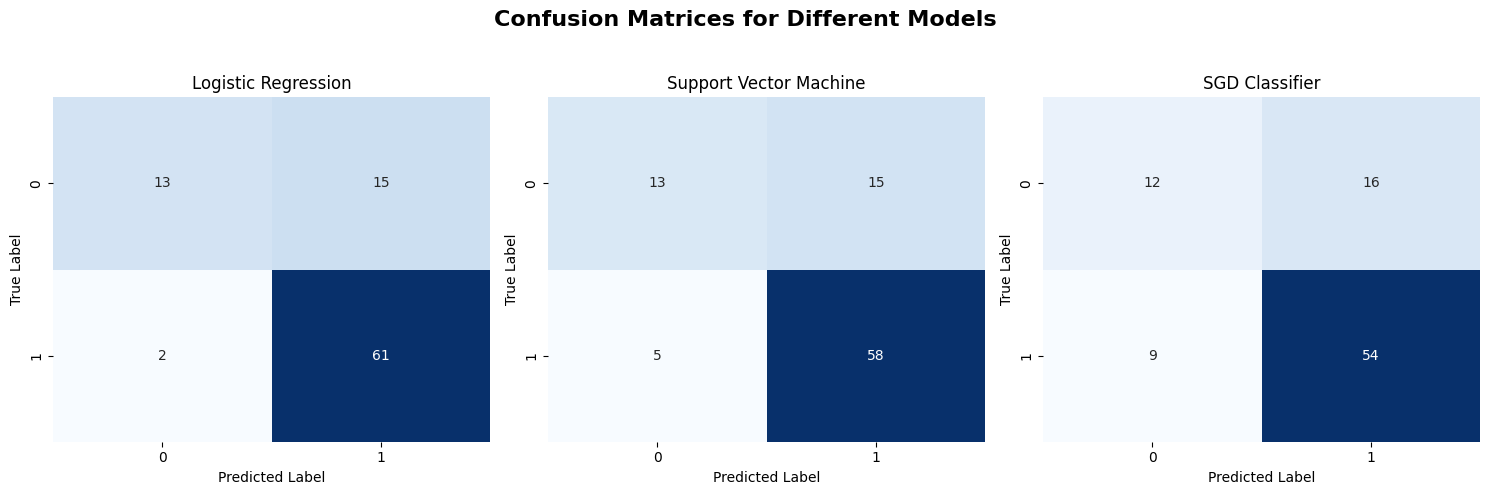

In [112]:
plt.figure(figsize=(15, 5))
plt.suptitle("Confusion Matrices for Different Models", fontsize=16, fontweight='bold')

# Loop through results to plot confusion matrices
for i, (name, result) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(name, fontsize=12)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [113]:
log_model = results['Logistic Regression']['model'] #Get Logistic Regression Model

explainer = shap.Explainer(log_model, X_train) #Create SHAP Explainer
shap_values = explainer(X_test) #Calculate SHAP values for test set

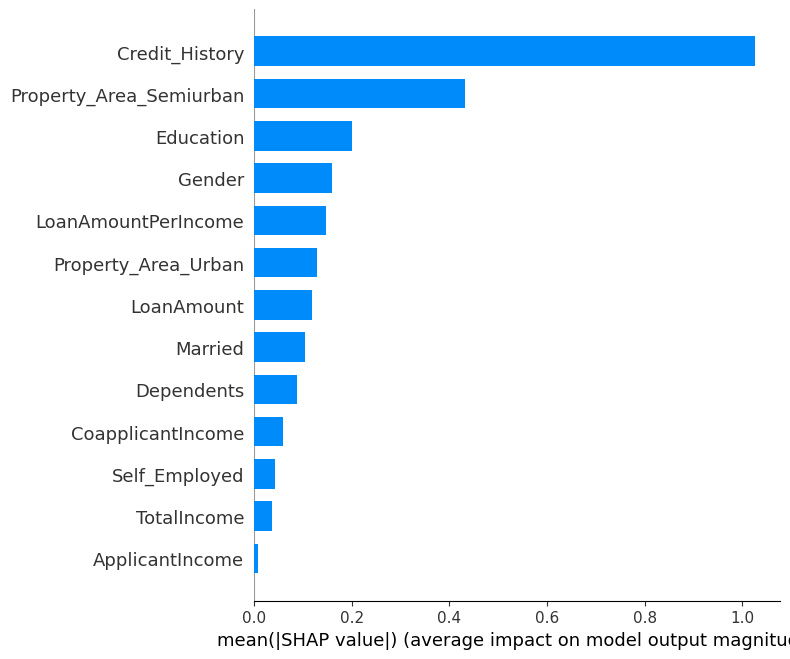

In [114]:
# Summary plot (global explanation)
shap.summary_plot(shap_values, X_test, plot_type="bar")


The Summary plot shows which features have the biggest impact on the prediction output. The model is highly dependent on Credit_History, which suggests that loan approval heavily favors those with past borrowing records.

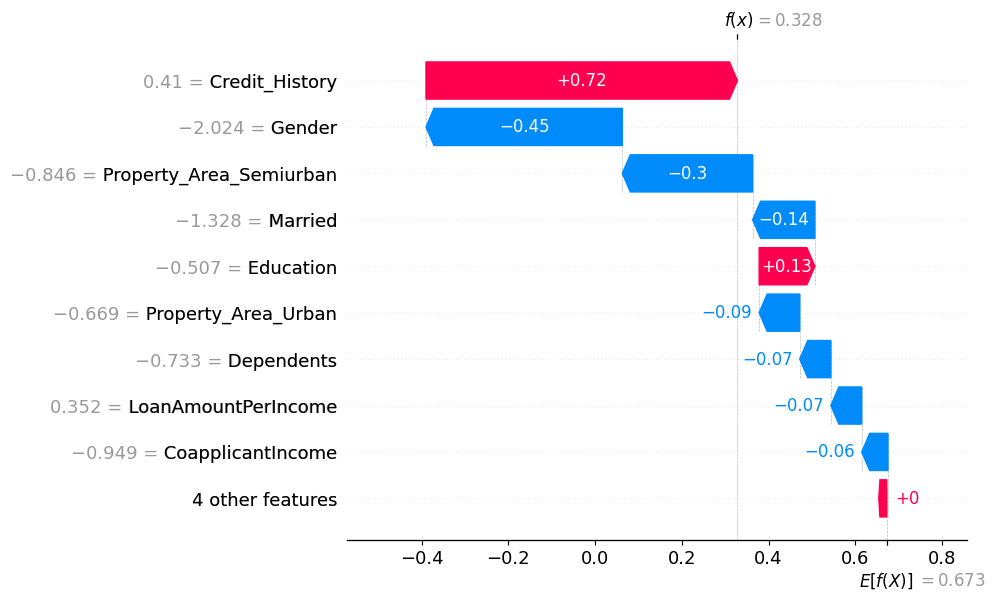

In [115]:
index = 5  # pick any test instance
shap.plots.waterfall(shap_values[index])
#This waterfall plot shows how each feature contributes to the final prediction for that specific instance.

the waterfall plot shows how features contribute to one specific prediction, we can see exactly why a given applicant was predicted as likely/unlikely to be approved. From the plot it is observed that Credit_History +0.72 increases the model’s predicted probability of loan approval. We also note that Gender and Property_Area_Semiurban with values of -0.45 and -0.3 respectively decrease the prediction probability of loan approved, possibly showing a bias where certain groups are less likely to be approved.

In essence, even if two applicants have similar incomes, differences in Credit_History or Gender could significantly change the model’s output.

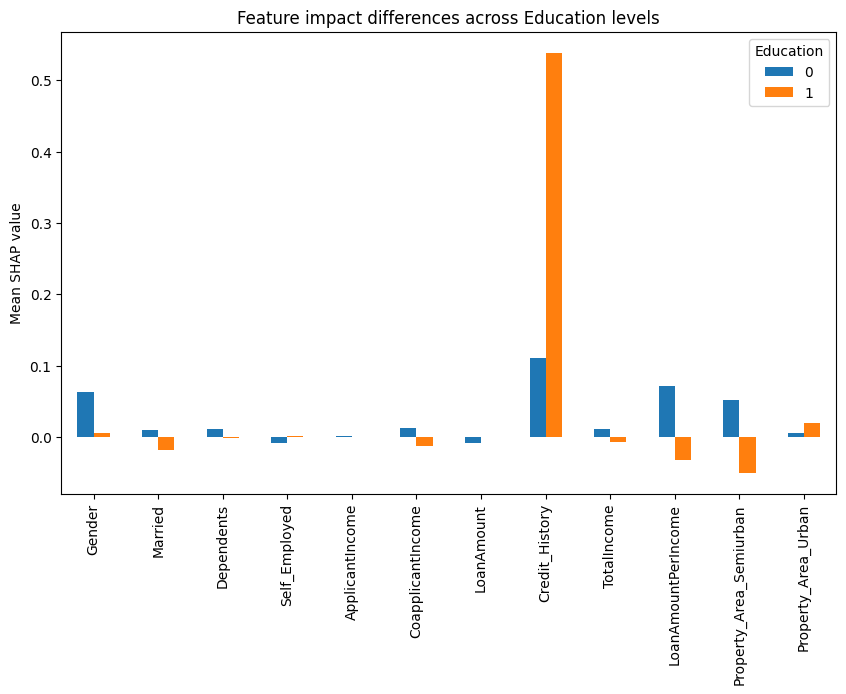

In [116]:
# Add SHAP values back to your dataframe
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns, index=X_test.index)
shap_df['Education'] = df_transformed['Education'].iloc[X_test.index].values

# Group and analyze mean absolute SHAP values per feature by group
group_shap = shap_df.groupby('Education').mean().T

# Plot
group_shap.plot(kind='bar', figsize=(10,6))
plt.title('Feature impact differences across Education levels')
plt.ylabel('Mean SHAP value')
plt.show()

this bar plot compares SHAP impacts by Education level. For Credit_History, the impact is much higher for educated applicants (Education=1). For Gender, the impact is larger for uneducated applicants (Education=0), suggesting gender affects less-educated applicants more strongly. The model’s decision process is not uniform across education levels and this hints that it may treat groups differently even if they have similar financial characteristics.

Bias and Fairness

The model relies most on Credit_History, which is generally fair. Gender appears influential which introduces potential gender bias. Differences in SHAP impact by Education show unequal treatment across groups.

To enhance transparency and fairness, it is recommended to conduct sensitivity analyses on protected features, adopting fairness aware model training, and regularly using SHAP visualizations to explain and monitor model decisions.